# Lab 3: time series forecast with Amazon SageMaker DeepAR


This notebook demonstrates how to use [Amazon SageMaker DeepAR](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html) algorithm for a real use case of predicting energy consumption of 370 customers over time, based on a [dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014) that was used in the academic papers [[1]](https://media.nips.cc/nipsbooks/nipspapers/paper_files/nips29/reviews/526.html) and [[2]](https://arxiv.org/abs/1704.04110).  

The SageMaker DeepAR forecasting algorithm is a supervised learning algorithm for forecasting scalar (one-dimensional) time series using recurrent neural networks (RNN). DeepAR was created by scientists at Amazon. Specifically, it was developed by researchers in Amazon's Core Machine Learning group. The [original paper](https://arxiv.org/abs/1704.04110) was published on arXiv in 2017.

Classical forecasting methods, such as autoregressive integrated moving average (ARIMA) or exponential smoothing (ETS), fit a single model to each individual time series. They then use that model to extrapolate the time series into the future.

In many applications, however, you have many similar time series across a set of cross-sectional units. For example, you might have time series groupings for demand for different products, server loads, and requests for webpages. For this type of application, you can benefit from training a single model jointly over all of the time series. DeepAR takes this approach. When your dataset contains hundreds of related time series, DeepAR outperforms the standard ARIMA and ETS methods. You can also use the trained model to generate forecasts for new time series that are similar to the ones it has been trained on. For information on the mathematics behind DeepAR, see [DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks](https://arxiv.org/abs/1704.04110).

In this notebook you learn how to:
- Prepare the dataset for DeepAR training
- Use the SageMaker Python SDK and a training job to train a DeepAR model
- Deploy a trained model as a real-time endpoint
- Make requests to the deployed model to obtain forecasts interactively
- Learn advanced features of DeepAR: missing values, additional time features, non-regular frequencies and category information

For more information see the DeepAR [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html).

This notebook is based on [SageMaker/DeepAR demo on electricity dataset notebook](https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/deepar_electricity/DeepAR-Electricity.ipynb) from a public GitHub repo [Amazon SageMaker examples](https://github.com/aws/amazon-sagemaker-examples/tree/main) and the blog post [Deep demand forecasting with Amazon SageMaker](https://aws.amazon.com/blogs/machine-learning/deep-demand-forecasting-with-amazon-sagemaker/).

## Implementations of DeepAR
There are several implementations of DeepAR algorithms:
- SageMaker DeepAR: this notebook demonstrates using this specific implementation
- [GluonTS DeepAR](https://ts.gluon.ai/stable/getting_started/models.html): GluonTS library includes many other algorithms for probabilisitic time series modeling. GluonTS provides [MXNet](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/mx/model/deepar/_estimator.py) and [PyTorch](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/torch/model/deepar/estimator.py) implementations of DeepAR.

## Import packages

In [1]:
%pip install -qU pip sagemaker boto3 s3fs jsonlines

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires nvidia-ml-py3==7.352.0, which is not installed.
aiobotocore 2.13.2 requires botocore<1.34.132,>=1.34.70, but you have botocore 1.35.43 which is incompatible.
amazon-sagemaker-sql-magic 0.1.3 requires sqlparse==0.5.0, but you have sqlparse 0.5.1 which is incompatible.
autogluon-core 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-features 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-multimodal 1.1.1 requires omegaconf<2.3.0,>=2.1.1, but you have omegaconf 2.3.0 which is incompatible.
autogluon-multimodal 1.1.1 requires scikit-learn<1.4.1,>=1.3.0, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-tabular 1.1.1 requires scikit-learn<1.4.1,>=1.3.0

In [2]:
from __future__ import print_function

%matplotlib inline

import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os
import jsonlines
import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from time import gmtime, strftime, sleep
import tqdm
from sagemaker.s3 import S3Downloader, S3Uploader

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox, Select

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Set literals and general variables

In [7]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [8]:
sagemaker_session = sagemaker.Session()

In [9]:
s3_bucket = sagemaker_session.default_bucket()  # replace with an existing bucket if needed
s3_prefix = "deepar-demo-notebook"  # prefix used for all data stored within the bucket
experiment_prefix = "deepar"

sm_role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [10]:
region = sagemaker_session.boto_region_name

s3_data_path = f"s3://{s3_bucket}/{s3_prefix}/data"
s3_output_path = f"s3://{s3_bucket}/{s3_prefix}/output"

Get the URI of the container image of the DeepAR algorithm container for the region that the notebook is running in.

In [11]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)

In [12]:
# maps of quota codes to instance types
ep_instance_quota_code_map = {
    "ml.m5.4xlarge":"L-E2649D46",
    "ml.m5.xlarge":"L-2F737F8D",
}

training_instance_quota_code_map = {
    "ml.c5.4xlarge":"L-E7898792",
    "ml.p2.xlarge":"L-5585E645",
    "ml.m5.4xlarge":"L-AFB011B4",
    "ml.c5.2xlarge":"L-49679826",
    "ml.m5.2xlarge":"L-AD0A282D",
}

In [13]:
# helper to check resource quota in the account
def check_quota(q_map, instance, min_n=1):
    quotas_client = boto3.client("service-quotas")


    r = quotas_client.get_service_quota(
        ServiceCode="sagemaker",
        QuotaCode=q_map[instance],
    )

    q = r["Quota"]["Value"]
    n = r["Quota"]["QuotaName"]
    min_n = min_n

    b = q >= min_n

    print(f"\033[92mSUCCESS: Quota {q} for {n} >= required {min_n}\033[0m" if b else f"\033[91mWARNING: Quota {q} for {n} < required {min_n}\033[0m")

    return b

# helper to get the first available instance in the quota map
def get_best_instance(q_map):
    l = [i for i in
            [i if check_quota(q_map, i) else None 
             for i in q_map.keys()] if i is not None]
    return l[0] if len(l) > 0 else ''

## Download the dataset

Download the from the SageMaker example S3 bucket. You use the [electricity dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014) from the repository of the University of California, Irvine:
> Trindade, Artur. (2015). ElectricityLoadDiagrams20112014. UCI Machine Learning Repository. https://doi.org/10.24432/C58C86.

In [14]:
os.makedirs("./data", exist_ok=True)

In [15]:
dataset_zip_file_name = 'LD2011_2014.txt.zip'
dataset_path = './data/LD2011_2014.txt'

s3_dataset_path = f"datasets/timeseries/uci_electricity/{dataset_zip_file_name}"

In [16]:
if not os.path.isfile(dataset_path):
    print(f'Downloading and unzipping the dataset to {dataset_path}')
    s3_client = boto3.client("s3")
    s3_client.download_file(
        f"sagemaker-example-files-prod-{region}", s3_dataset_path, f"./data/{dataset_zip_file_name}"
    )

    zip_ref = zipfile.ZipFile(f"./data/{dataset_zip_file_name}", "r")
    zip_ref.extractall("./data")
    zip_ref.close()
    dataset_path = '.'.join(zip_ref.filename.split('.')[:-1])
else:
    print(f'The dataset {dataset_path} exists, skipping download and unzip!')

The dataset ./data/LD2011_2014.txt exists, skipping download and unzip!


In [17]:
# !head {dataset_path}

## Explore and preprocess data
Load the dataset and convert it to a collection of Pandas time series, which makes common time series operations such as indexing by time periods or resampling much easier. The data is originally recorded in 15 min interval, which you could use directly. This example forecasts longer periods (one week) and resample the data to a granularity of 2 hours.

In [18]:
df_raw = pd.read_csv(
    dataset_path, 
    sep=';', 
    index_col=0,
    decimal=',',
    parse_dates=True,
)

In [19]:
df_raw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:30:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 00:45:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 01:15:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541


In [20]:
# resample to 2h intervals
freq = "2h"
div = 8 # 2 hours contain 8x 15 min intervals, you need to  delete the resampled value by 8

data_kw = df_raw.resample(freq).sum() / div
data_kw

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-01-01 08:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 16:00:00,2.379442,28.538407,1.954822,160.569106,67.225610,260.416667,7.560769,352.693603,75.830420,53.897849,...,439.864383,40675.0,2816.983122,3980.113636,127.933507,7.753072,504.938543,118.948247,703.445748,12033.783784
2014-12-31 18:00:00,2.220812,28.449502,2.172024,208.587398,91.310976,385.788690,12.719050,359.427609,95.498252,84.408602,...,425.053533,43300.0,2793.776371,3454.545455,105.606258,5.266238,500.877963,47.787980,706.011730,9554.054054
2014-12-31 20:00:00,2.379442,24.004267,1.737619,174.288618,89.176829,330.357143,11.447145,292.508418,84.134615,75.806452,...,330.389008,39137.5,1676.160338,1857.954545,74.967405,4.169105,420.654083,131.886477,675.219941,8344.594595
2014-12-31 22:00:00,2.062183,21.692745,1.737619,161.331301,85.365854,311.383929,11.023177,251.262626,68.181818,72.446237,...,289.079229,31775.0,1591.244726,1303.977273,46.284224,7.533645,665.605795,178.422371,669.263196,7263.513514


Create a smaller dataset with a subset of time series:

In [21]:
# select two random time series to include in a small dataset
sample_size = 2
columns_to_keep = np.random.choice(data_kw.columns.to_list(), size=sample_size, replace=False)
columns_to_keep

array(['MT_328', 'MT_034'], dtype='<U6')

In [22]:
data_kw_small = data_kw[columns_to_keep]
data_kw_small

,MT_328,MT_034
2011-01-01 00:00:00,531.481481,0.000000
2011-01-01 02:00:00,580.555556,0.000000
2011-01-01 04:00:00,577.777778,0.000000
2011-01-01 06:00:00,632.407407,0.000000
2011-01-01 08:00:00,740.740741,0.000000
...,...,...
2014-12-31 16:00:00,1451.851852,18.505587
2014-12-31 18:00:00,1321.296296,33.170391
2014-12-31 20:00:00,649.074074,30.638966
2014-12-31 22:00:00,538.888889,31.424581


<div class="alert alert-info">
To reduce the training time you can use a subset of time series instead of the full dataset with 370 time series.
</div>

For AWS-led workshop please choose a small dataset by leaving the `USE_FULL_DATASET` on it's default value `False`. The training time for the small dataset is about 18-20 minutes depending on the used training instance. The train time for the full dataset is about 25 minutes for `ml.c5.4xlarge` instance.

In [23]:
USE_FULL_DATASET = False

In [24]:
if USE_FULL_DATASET:
    ts_df = data_kw
else:
    ts_df = data_kw_small

In [25]:
# convert the DataFrame to a list of pandas.Series objects
timeseries = []

for i in tqdm.trange(ts_df.shape[1]):
    timeseries.append(np.trim_zeros(ts_df.iloc[:, i], trim="f"))

100%|██████████| 2/2 [00:00<00:00, 2145.42it/s]


Plot the time series for random ids for the time period spanning the first four weeks of 2014.

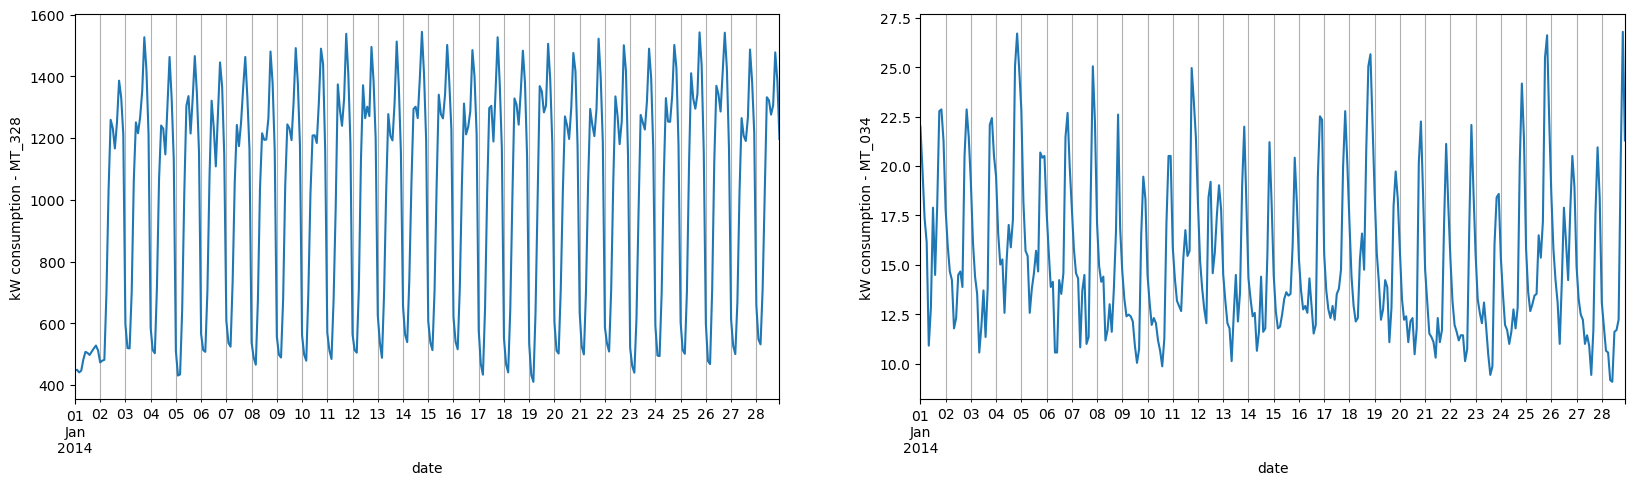

In [26]:
# show random timeseries for 28 day period
sample_size = min(ts_df.shape[1], 10)

n_rows = (sample_size+1)//2
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows), sharex=True)
axx = axs.ravel()
for i, ts in enumerate(random.sample(timeseries, sample_size)):
    series = ts.loc["2014-01-01":"2014-01-28"]
    if len(series): series.plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel(f"kW consumption - {ts.name}")
    axx[i].grid(which="minor", axis="x")

## Prepare train and test datasets

For model evaluation or tuning algorithm's hyperparameters you need to create a hold-out test dataset. Split the available data into train and test sets for evaluating the trained model. For standard ML tasks such as classification and regression, you typically obtain this split by randomly separating examples into train and test sets. On contrary, in forecasting it is important to do split based on time rather than by time series to keep all data point sequential.

In this example, reserve the last section of each of the time series for evalutation purpose and use only the first part as training data. 

In [27]:
# predict for 7 days
prediction_days = 7
intervals_per_day = 12
prediction_length = prediction_days * intervals_per_day

# use same period as the context length, this is the number of state updates accomplished before making predictions
context_length = prediction_days * intervals_per_day

Specify the portion of the data that is used for training. Note that you use a data portion from the middle of the dataset to have target data points for backtesting. Feel free to change the boundaries.

In [27]:
start_dataset = pd.Timestamp("2012-01-01 00:00:00", unit=freq)
end_training = pd.Timestamp("2014-09-01 00:00:00", unit=freq)
print(f"the model sees data from {start_dataset} to {end_training} for training.")

the model sees data from 2012-01-01 00:00:00 to 2014-09-01 00:00:00 for training.


The DeepAR JSON [input format](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar-inputoutput) represents each time series as a JSON object. In the simplest case each time series just consists of a start time stamp (``start``) and a list of values (``target``). For more complex cases, DeepAR also supports the fields ``dynamic_feat`` for time-series features and ``cat`` for categorical features, which you can explore later in this notebook.

In [28]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[
            start_dataset : end_training - timedelta(days=1)
        ].tolist(),  # use -1, because pandas indexing includes the upper bound
    }
    for ts in timeseries
]
print(f"Training for {len(training_data)} time series")

Training for 370 time series


For test data, consider time series extending beyond the training range: these are used for computing test scores by using the trained model to forecast the rolling 7 days and comparing predictions with actual values.
To evaluate the model performance on more than one week, generate test data that extends to 1, 2, 3, and 4 weeks beyond the training range. This performs *rolling evaluation* of the model.

In [29]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset : end_training + timedelta(days=k * prediction_length)].tolist(),
    }
    for k in range(1, num_test_windows + 1)
    for ts in timeseries
]
print(len(test_data))

1480


Write the dictionary to the `jsonlines` file format that DeepAR understands. Other supported input formats are _gzipped jsonlines_ and _parquet_.

In [30]:
def write_dicts_to_file(path, data):
    with open(path, "wb") as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode("utf-8"))

In [31]:
%%time
write_dicts_to_file("./data/train.json", training_data)
write_dicts_to_file("./data/test.json", test_data)

CPU times: user 12.2 s, sys: 172 ms, total: 12.4 s
Wall time: 12.4 s


In [32]:
print(f"Content of the DeepAR training/test dataset file:")

# Read the jsonl file and show the head an the tail of the first object
with jsonlines.open(f"./data/train.json") as reader:      
    sample = json.dumps(reader.read(), indent=2)
    print(f"{sample[:200]}...\n{sample[len(sample)-200:]}")

Content of the DeepAR training/test dataset file:
{
  "start": "2012-01-01 00:00:00",
  "target": [
    3.6484771573604062,
    4.6002538071066,
    4.6002538071066015,
    4.441624365482235,
    2.5380710659898473,
    14.118020304568534,
    3.9657...
314738,
    15.06979695431474,
    14.752538071066013,
    18.401015228426413,
    14.911167512690376,
    19.035532994923862,
    16.180203045685275,
    16.656091370558364,
    16.497461928934
  ]
}


Upload the training and test datasets to S3 where the DeepAR training job can access them.

In [33]:
!aws s3 rm {s3_data_path}/train/ --recursive
!aws s3 rm {s3_data_path}/test/ --recursive

delete: s3://sagemaker-us-east-1-906545278380/deepar-demo-notebook/data/train/train.json
delete: s3://sagemaker-us-east-1-906545278380/deepar-demo-notebook/data/test/test.json


In [34]:
!aws s3 cp ./data/train.json {s3_data_path}/train/train.json
!aws s3 cp ./data/train.json {s3_data_path}/test/test.json

upload: data/train.json to s3://sagemaker-us-east-1-906545278380/deepar-demo-notebook/data/train/train.json
upload: data/train.json to s3://sagemaker-us-east-1-906545278380/deepar-demo-notebook/data/test/test.json


All is set with dataset processing, now call DeepAR to train a model and generate predictions.

## Train a DeepAR model

Define the estimator that uses the built-in DeepAR algorithm container image.

DeepAR [supports](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html#deepar-instances) training with GPU instances. You can use any of two instances below. GPU acceleration is less pronounced on small datasets and recommended for datasets with many cells per layer and many layers and for large batch sizes.

For inference, DeepAR supports only CPU instances.

In [35]:
# select the instance based on the quota availability
instance_type = get_best_instance(training_instance_quota_code_map)

assert instance_type, "You don't have quotas for required processing instance"

SUCCESS: Quota 8.0 for ml.c5.4xlarge for training job usage >= required 1
SUCCESS: Quota 1.0 for ml.p2.xlarge for training job usage >= required 1
SUCCESS: Quota 50.0 for ml.m5.4xlarge for training job usage >= required 1
SUCCESS: Quota 30.0 for ml.c5.2xlarge for training job usage >= required 1
SUCCESS: Quota 30.0 for ml.m5.2xlarge for training job usage >= required 1


In [36]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=sm_role,
    instance_count=1,
    instance_type=instance_type,
    base_job_name="deepar-demo-notebook",
    output_path=s3_output_path,
)

Set the [hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_hyperparameters.html) for the training job. For example frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train like number of layers, number of cells per layer, likelihood function, and the training options such as number of epochs, batch size, learning rate. 
This example uses default parameters for every optional parameter in this case. 

In [37]:
hyperparameters = {
    "time_freq": freq.upper(),
    "epochs": "200", # you can reduce number of epochs for faster training: 100 epochs takes about 14 min to train
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
}

In [38]:
estimator.set_hyperparameters(**hyperparameters)

Launch the training job. SageMaker will start an EC2 instance, download the ECR image with the algorithm container, download the data from S3, start training the model, and save the trained model to S3 when training finishes.

If you provide the `test` data channel as you do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test. This is done by predicting the last `prediction_length` points of each time-series in the test set and comparing this to the actual value of the time-series. 

**Note:** the training takes about to 20 minutes complete on a `ml.c5.4xlarge` instance.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
The training takes about 20-25 minutes. Please take this time to work on the next lab in this workshop and come back to this notebook later on.
</div>

In [ ]:
%%time
data_channels = {"train": "{}/train/".format(s3_data_path), "test": "{}/test/".format(s3_data_path)}

estimator.fit(inputs=data_channels, wait=True)

Since you provide a test dataset in this example, accuracy metrics for the forecast are computed and logged (see bottom of the log).
You can find the definition of these metrics from [DeepAR documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-tuning.html#deepar-metrics). You can use these to optimize the parameters and tune your model or use SageMaker's [automated model tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html) as described in the [blog post](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/).

The next code cell retrieves model metrics [computed](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-tuning.html#deepar-metrics) by the DeepAR algorithm:

In [40]:
# Show the metrics computed by the DeepAR algorithm
model_metrics_df = estimator.training_job_analytics.dataframe()
metrics_filter = ['test:RMSE', 'test:mean_wQuantileLoss', 'train:final_loss']
# Filter the DataFrame
model_metrics_df = model_metrics_df[model_metrics_df['metric_name'].isin(metrics_filter)]

model_metrics_df

,timestamp,metric_name,value
0,0.0,test:mean_wQuantileLoss,0.057791
41,0.0,train:final_loss,3.756619
55,0.0,test:RMSE,640.369811


### Save the model performance to a file

In [41]:
os.makedirs("./model-performance", exist_ok=True)

In [42]:
experiment_name = f"{experiment_prefix}-{freq}-{ts_df.shape[1]}-{ts_df.shape[0]}"
timestamp = strftime("%Y%m%d-%H%M%S", gmtime())

In [43]:
experiment_name

'deepar-2h-370-17533'

In [44]:
model_metrics_df['experiment'] = experiment_name
model_metrics_df['timestamp'] = timestamp
model_metrics_df = model_metrics_df[['timestamp','metric_name','value','experiment']]
model_metrics_df

,timestamp,metric_name,value,experiment
0,20240930-104323,test:mean_wQuantileLoss,0.057791,deepar-2h-370-17533
41,20240930-104323,train:final_loss,3.756619,deepar-2h-370-17533
55,20240930-104323,test:RMSE,640.369811,deepar-2h-370-17533


In [45]:
model_metrics_df.to_csv(f'./model-performance/{experiment_name}-{timestamp}.csv', index=False)

## Evaluate the model

### Create an endpoint and predictor

Now that you have a trained model, you can use it to perform predictions by deploying it to an endpoint.

<div class="alert alert-info">Make sure you delete the endpoint by completing the clean up section at the end of the notebook</div>

To query the endpoint and perform predictions, define the following utility class. This allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [46]:
from sagemaker.serializers import IdentitySerializer

In [47]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(
        self,
        ts,
        cat=None,
        dynamic_feat=None,
        num_samples=100,
        return_samples=False,
        quantiles=["0.1", "0.5", "0.9"],
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)

    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(
            ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None
        )

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles,
        }

        http_request_data = {"instances": [instance], "configuration": configuration}

        return json.dumps(http_request_data).encode("utf-8")

    def __decode_response(self, response, freq, prediction_time, return_samples):
        # the example sends one time series and receives one in return
        # however, if possible to pass multiple time series as predictions be faster
        predictions = json.loads(response.decode("utf-8"))["predictions"][0]
        prediction_length = len(next(iter(predictions["quantiles"].values())))
        prediction_index = pd.date_range(
            start=prediction_time, freq=freq, periods=prediction_length
        )
        if return_samples:
            dict_of_samples = {"sample_" + str(i): s for i, s in enumerate(predictions["samples"])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(
            data={**predictions["quantiles"], **dict_of_samples}, index=prediction_index
        )

    def set_frequency(self, freq):
        self.freq = freq


def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]


def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj

Deploy the model and create a real-time SageMaker endpoint that can be queried using the custom DeepARPredictor class.

In [48]:
# select the instance based on the quota availability
ep_instance_type = get_best_instance(ep_instance_quota_code_map)

assert ep_instance_type, "You don't have quotas for required endpoint instance"

SUCCESS: Quota 4.0 for ml.m5.4xlarge for endpoint usage >= required 1
SUCCESS: Quota 38.0 for ml.m5.xlarge for endpoint usage >= required 1


<div class="alert alert-info">If you get an exception <code>ResourceLimitExceeded</code> when calling the <code>deploy()</code> method, you might already utilize the available quota for the specific type of ML instances. Try another instance for what you have a quota available or delete an existing endpoint if you don't need it anymore.</div>

In [49]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type=ep_instance_type,
    predictor_cls=DeepARPredictor
)

INFO:sagemaker:Creating model with name: deepar-demo-notebook-2024-10-01-08-20-26-071
INFO:sagemaker:Creating endpoint-config with name deepar-demo-notebook-2024-10-01-08-20-26-071
INFO:sagemaker:Creating endpoint with name deepar-demo-notebook-2024-10-01-08-20-26-071


---------------!

### Make predictions and plot results

Now you can use the `predictor` object to generate predictions.

In [50]:
predictor.predict(ts=random.sample(timeseries, 1)[0], quantiles=[0.10, 0.5, 0.90]).head()

,0.1,0.5,0.9
2015-01-01 02:00:00,40.328037,52.031166,63.182205
2015-01-01 04:00:00,42.327587,54.828438,65.817902
2015-01-01 06:00:00,84.429077,103.034409,127.885498
2015-01-01 08:00:00,97.304939,123.756805,149.162460
2015-01-01 10:00:00,96.224991,130.737930,156.271210


Define a plotting function that queries the model and displays the forecast.

In [51]:
def plot(
    predictor,
    target_ts,
    cat=None,
    dynamic_feat=None,
    forecast_date=end_training,
    show_samples=False,
    plot_history=7 * 12,
    confidence=80,
):
    freq = target_ts.index.freq
    print(
        "calling served model to generate predictions starting from {}".format(str(forecast_date))
    )
    assert confidence > 50 and confidence < 100
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5

    # construct the argument to call the model
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": 100,
    }

    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(1, 1, 1)

    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, "cat = {}".format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    if show_samples:
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color="lightskyblue", alpha=0.2, label="_nolegend_")

    # plot the target
    target_section = target_ts[
        forecast_date - plot_history * freq : forecast_date + prediction_length * freq
    ]
    target_section.plot(color="black", label="target")

    # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index,
        prediction[str(low_quantile)].values,
        prediction[str(up_quantile)].values,
        color="b",
        alpha=0.3,
        label="{}% confidence interval".format(confidence),
    )
    prediction["0.5"].plot(color="b", label="P50")
    ax.legend(loc=2)

    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)

    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.date_range(
                    start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)
                ),
                data=f,
            )
            feat_ts[
                forecast_date - plot_history * freq : forecast_date + prediction_length * freq
            ].plot(ax=ax, color="g")

    plt.tight_layout()
    plt.show()

Interact with the function previously defined to look at the forecast of any time series at any point in future time. 

For each request, the predictions are obtained by calling the deployed model as the real-time endpoint.
You can change the following parameters:
- `Time series id:`: id of the time series
- `Offset`: if set to 0, the forecast starts from the end of the training period. You can enter a negative number which specifies how many days **before** the end of the training period the forecast starts. Positive number specifies how many days **after** the end on the training period the forecast starts. This allows you to see the actual values - shown as **target** on the plot - together with the predictions
- `Confidence`: confidence interval for the predictions
- `History length`: how `prediction lengths` of history are shown on the plot

For example, forecast the consumption of an office after week-end and note the lower week-end consumption.
You can select any time series and any forecast date, just click on `Run Interact` to generate the predictions from the `end_training` + `offset` and see the plot.

In [52]:
style = {"description_width": "initial"}
ts_id_list = [ts.name for ts in timeseries]

In [53]:
@interact_manual(
    ts_ids=Select(options=ts_id_list, value=ts_id_list[0], rows=5, description='Time series id:'),
    offset=IntSlider(min=-100, max=100, value=0, style=style, description='Offset:'),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style, description='Confidence:'),
    history_length=IntSlider(min=2, max=20, value=2, style=style, description='History length:'),
    show_samples=Checkbox(value=False, description='Show samples'),
    continuous_update=False,
)
def plot_interact(ts_ids, offset, confidence, history_length, show_samples):
    plot(
        predictor,
        target_ts=[ts for ts in timeseries if ts.name in ts_ids][0],
        forecast_date=end_training + datetime.timedelta(days=offset),
        show_samples=show_samples,
        plot_history=history_length * prediction_length,
        confidence=confidence,
    )

interactive(children=(Select(description='Time series id:', options=('MT_001', 'MT_002', 'MT_003', 'MT_004', '…

### Clean up

In [54]:
predictor.delete_model()
predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: deepar-demo-notebook-2024-10-01-08-20-26-071
INFO:sagemaker:Deleting endpoint configuration with name: deepar-demo-notebook-2024-10-01-08-20-26-071
INFO:sagemaker:Deleting endpoint with name: deepar-demo-notebook-2024-10-01-08-20-26-071


---

## Optional: DeepAR additional features

You have seen how to prepare a dataset and run DeepAR for a simple example.

In addition DeepAR supports the following features:

* missing values: DeepAR can handle missing values in the time series during training as well as for inference.
* [Additional time features](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_how-it-works.html#deepar_under-the-hood): DeepAR provides a set default time series features such as hour of day etc. However, you can provide additional feature time series via the `dynamic_feat` field. 
* generalize frequencies: any integer multiple of the previously supported base frequencies (minutes `min`, hours `H`, days `D`, weeks `W`, month `M`) are now allowed; e.g., `15min`. It's already demonstrated above by using `2H` frequency.
* categories: If your time series belong to different groups (e.g. types of product, regions, etc), this information can be encoded as one or more categorical features using the `cat` field.

This section demonstrates the missing values and time features support. It uses the same electricity dataset but does some artificial changes to demonstrate the new features: 
* Randomly mask parts of the time series to demonstrate the missing values support.
* Include a "special-day" that occurs at different days for different time series. This "special-day" introduces a strong up-lift.
* Train the model on this dataset giving "special-day" as a custom time series feature

<div class="alert alert-info">This section is intended for self-work, don't run this session if you're participating in an AWS-led workshop.</div>

### Prepare dataset

As discussed above create a "special-day" feature and create an up-lift for the time series during this day. This simulates real world application where you may have things like promotions of a product for a certain time or a special event that influences your time series. 

In [131]:
def create_special_day_feature(ts, fraction=0.05):
    # First select random day indices (plus the forecast day)
    num_days = (ts.index[-1] - ts.index[0]).days
    rand_indices = list(np.random.randint(0, num_days, int(num_days * 0.1))) + [num_days]

    feature_value = np.zeros_like(ts)
    for i in rand_indices:
        feature_value[i * 12 : (i + 1) * 12] = 1.0
    feature = pd.Series(index=ts.index, data=feature_value)
    return feature


def drop_at_random(ts, drop_probability=0.1):
    assert 0 <= drop_probability < 1
    random_mask = np.random.random(len(ts)) < drop_probability
    return ts.mask(random_mask)

In [132]:
special_day_features = [create_special_day_feature(ts) for ts in timeseries]

In [133]:
special_day_features[0]

2011-01-01 00:00:00    0.0
2011-01-01 02:00:00    0.0
2011-01-01 04:00:00    0.0
2011-01-01 06:00:00    0.0
2011-01-01 08:00:00    0.0
                      ... 
2014-12-31 16:00:00    0.0
2014-12-31 18:00:00    0.0
2014-12-31 20:00:00    0.0
2014-12-31 22:00:00    0.0
2015-01-01 00:00:00    1.0
Freq: 2h, Length: 17533, dtype: float64

Create the up-lifted time series and randomly remove time points.

The figures below show some example time series and the `special_day` feature value in green. 

In [168]:
timeseries_uplift = [ts * (1.0 + feat) for ts, feat in zip(timeseries, special_day_features)]
time_series_processed = [drop_at_random(ts) for ts in timeseries_uplift]

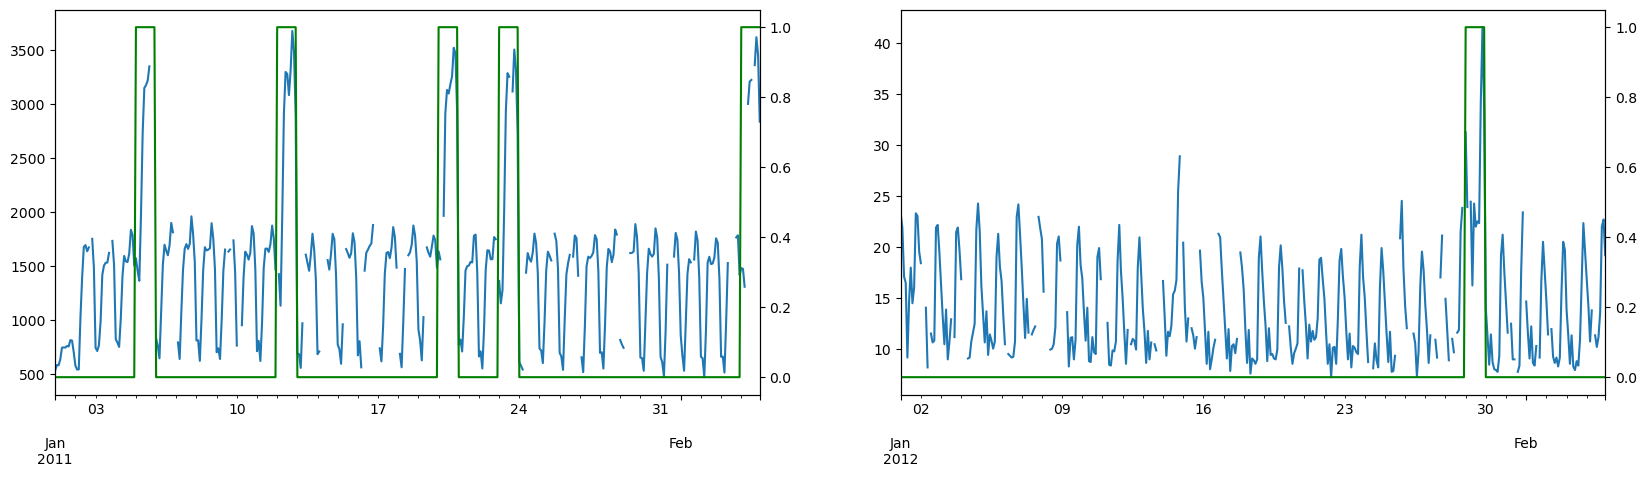

In [196]:
sample_size = min(ts_df.shape[1], 10)

n_rows = (sample_size+1)//2
n_cols = 2
history = prediction_length*5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axx = axs.ravel()
for i in range(sample_size):
    time_series_processed[i][:history].plot(ax=axx[i])
    special_day_features[i][:history].plot(ax=axx[i].twinx(), color="g")

### Create train and test datasets

In [197]:
%%time

training_data_new_features = [
    {
        "start": str(start_dataset),
        "target": encode_target(ts[start_dataset:end_training]),
        "dynamic_feat": [special_day_features[i][start_dataset:end_training].tolist()],
    }
    for i, ts in enumerate(time_series_processed)
]
print(len(training_data_new_features))

# as in the previous example, do a rolling evaluation over the next 7 days
num_test_windows = 7

test_data_new_features = [
    {
        "start": str(start_dataset),
        "target": encode_target(
            ts[start_dataset : end_training + 2 * k * prediction_length * ts.index.freq]
        ),
        "dynamic_feat": [
            special_day_features[i][
                start_dataset : end_training + 2 * k * prediction_length * ts.index.freq
            ].tolist()
        ],
    }
    for k in range(1, num_test_windows + 1)
    for i, ts in enumerate(timeseries_uplift)
]

2
CPU times: user 154 ms, sys: 7.87 ms, total: 162 ms
Wall time: 161 ms


In [198]:
def check_dataset_consistency(train_dataset, test_dataset=None):
    d = train_dataset[0]
    has_dynamic_feat = "dynamic_feat" in d
    if has_dynamic_feat:
        num_dynamic_feat = len(d["dynamic_feat"])
    has_cat = "cat" in d
    if has_cat:
        num_cat = len(d["cat"])

    def check_ds(ds):
        for i, d in enumerate(ds):
            if has_dynamic_feat:
                assert "dynamic_feat" in d
                assert num_dynamic_feat == len(d["dynamic_feat"])
                for f in d["dynamic_feat"]:
                    assert len(d["target"]) == len(f)
            if has_cat:
                assert "cat" in d
                assert len(d["cat"]) == num_cat

    check_ds(train_dataset)
    if test_dataset is not None:
        check_ds(test_dataset)


check_dataset_consistency(training_data_new_features, test_data_new_features)

In [199]:
%%time
write_dicts_to_file("./data/train_new_features.json", training_data_new_features)
write_dicts_to_file("./data/test_new_features.json", test_data_new_features)

CPU times: user 140 ms, sys: 4 ms, total: 144 ms
Wall time: 143 ms


In [200]:
s3_data_path_new_features = f"s3://{s3_bucket}/{s3_prefix}/new-features/data"
s3_output_path_new_features = f"s3://{s3_bucket}/{s3_prefix}/new-features/output"

In [201]:
!aws s3 cp ./data/train_new_features.json {s3_data_path_new_features}/train/test_new_features.json
!aws s3 cp ./data/test_new_features.json {s3_data_path_new_features}/test/test_new_features.json

upload: data/train_new_features.json to s3://sagemaker-us-east-1-361769591734/deepar-demo-notebook/new-features/data/train/test_new_features.json
upload: data/test_new_features.json to s3://sagemaker-us-east-1-361769591734/deepar-demo-notebook/new-features/data/test/test_new_features.json


### Train the model
The model training takes about 25-35 minutes.

In [202]:
%%time
estimator_new_features = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=sm_role,
    instance_count=1,
    instance_type=instance_type,
    base_job_name="deepar-demo-notebook-new-features",
    output_path=s3_output_path_new_features,
)

hyperparameters = {
    "time_freq": freq.upper(),
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "epochs": "200",
    "learning_rate": "5E-4",
    "mini_batch_size": "64",
    "early_stopping_patience": "40",
    "num_dynamic_feat": "auto",  # this will use the `dynamic_feat` field if it's present in the data
}
estimator_new_features.set_hyperparameters(**hyperparameters)

CPU times: user 6.05 ms, sys: 7.87 ms, total: 13.9 ms
Wall time: 12.9 ms


In [ ]:
estimator_new_features.fit(
    inputs={
        "train": f"{s3_data_path_new_features}/train/",
        "test": f"{s3_data_path_new_features}/test/",
    },
    wait=True,
)

In [204]:
# Show the metrics computed by the DeepAR algorithm
model_metrics_df = estimator_new_features.training_job_analytics.dataframe()
metrics_filter = ['test:RMSE', 'test:mean_wQuantileLoss', 'train:final_loss']
# Filter the DataFrame
model_metrics_df = model_metrics_df[model_metrics_df['metric_name'].isin(metrics_filter)]

model_metrics_df

,timestamp,metric_name,value
0,0.0,test:mean_wQuantileLoss,0.087313
71,0.0,train:final_loss,3.221323
95,0.0,test:RMSE,133.963902


### Evaluate the model
As before, deploy a model as a real-time endpoint to visualize forecasts on examples you send to the endpoint.

<div class="alert alert-info">If you get an exception <code>ResourceLimitExceeded</code> when calling the <code>deploy()</code> method, you might already utilize the available quota for the specific type of ML instances. Try another instance for what you have a quota available or delete an existing endpoint if you don't need it anymore.</div>

In [205]:
%%time
predictor_new_features = estimator_new_features.deploy(
    initial_instance_count=1, 
    instance_type=ep_instance_type, 
    predictor_cls=DeepARPredictor
)

INFO:sagemaker:Creating model with name: deepar-demo-notebook-new-features-2024-09-27-13-47-51-139
INFO:sagemaker:Creating endpoint-config with name deepar-demo-notebook-new-features-2024-09-27-13-47-51-139
INFO:sagemaker:Creating endpoint with name deepar-demo-notebook-new-features-2024-09-27-13-47-51-139


-------------!CPU times: user 82.9 ms, sys: 3.72 ms, total: 86.6 ms
Wall time: 7min 2s


In [206]:
item_id = 0
predictor_new_features.predict(
    ts=time_series_processed[item_id][:-prediction_length],
    dynamic_feat=[special_day_features[item_id].tolist()],
    quantiles=[0.1, 0.5, 0.9],
).head()

,0.1,0.5,0.9
2014-12-25 02:00:00,445.320038,513.660889,569.843689
2014-12-25 04:00:00,476.936401,547.002930,614.072266
2014-12-25 06:00:00,698.614868,754.053528,844.121277
2014-12-25 08:00:00,1046.855469,1120.133301,1230.026611
2014-12-25 10:00:00,1237.915283,1340.592041,1439.103638


You can query the endpoint to see predictions for arbitrary time series and time points.

In [208]:
@interact_manual(
    item_id=IntSlider(min=0, max=len(time_series_processed)-1, value=120, style=style),
    offset=IntSlider(min=-100, max=100, value=0, style=style, description='Offset:'),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style, description='Confidence:'),
    missing_ratio=FloatSlider(min=0.0, max=0.95, value=0.2, step=0.05, style=style, description='Missing ratio:'),
    show_samples=Checkbox(value=False, description='Show samples'),
    continuous_update=False,
)
def plot_interact(item_id, offset, confidence, missing_ratio, show_samples):
    forecast_date = end_training + datetime.timedelta(days=offset)
    ts = time_series_processed[item_id]
    freq = ts.index.freq
    target = ts[start_dataset : forecast_date + prediction_length * freq]
    target = drop_at_random(target, missing_ratio)
    dynamic_feat = [
        special_day_features[item_id][
            start_dataset : forecast_date + prediction_length * freq
        ].tolist()
    ]
    plot(
        predictor_new_features,
        target_ts=target,
        dynamic_feat=dynamic_feat,
        forecast_date=forecast_date,
        show_samples=show_samples,
        plot_history=2*prediction_length,
        confidence=confidence,
    )

interactive(children=(IntSlider(value=1, description='item_id', max=1, style=SliderStyle(description_width='in…

### Clean up

In [209]:
predictor_new_features.delete_model()
predictor_new_features.delete_endpoint()

INFO:sagemaker:Deleting model with name: deepar-demo-notebook-new-features-2024-09-27-13-47-51-139
INFO:sagemaker:Deleting endpoint configuration with name: deepar-demo-notebook-new-features-2024-09-27-13-47-51-139
INFO:sagemaker:Deleting endpoint with name: deepar-demo-notebook-new-features-2024-09-27-13-47-51-139


---

## Shutdown kernel

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>